In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
import sys
sys.path.append("../../")
from src.mps import mps
from src.mps import tebd
from src.tdvp import tdvp
from src.mps import tfi_model
from src.mps import mps_runge_kutta

In this notebook we will compare the time evolution of the two-site Time Dependent Variational Principle (TDVP) method with standard Time Evolving Block Decimation (TEBD), using the transverse field ising model (TFI) as an example.

In [3]:
def overlap(bra, ket):
    L = len(bra.Bs)
    assert(L == len(ket.Bs))
    left = np.ones(1)
    left = np.reshape(left, (1, 1))
    for n in range(L):
        # Contract left with bra
        left = np.tensordot(left, bra.Bs[n].conj(), (0, 0))
        # Contract left with ket
        left = np.tensordot(left, ket.Bs[n], [(0, 1), (0, 1)])
    return left[0, 0]

# TEBD

In [4]:
L = 14

In [5]:
MPS_all_spin_up = mps.MPS.initialize_spinup(L)

In [6]:
sigma_z = np.array([[1.0, 0.0], [0.0, -1.0]])
sigma_x = np.array([[0.0, 1.0], [1.0, 0.0]])

In [7]:
J = 1.
g = 1.5
chi_max = 100
eps = 1.e-10
dts_TEBD = [0.1, 0.01]
t_stop = 10*J

In [8]:
ms_TEBD = [[] for i in range(len(dts_TEBD))]

model = tfi_model.TFIModel(L, J, g)

for i, dt in enumerate(dts_TEBD):
    start = time.time()
    print("computing for dt =", dt)
    N = (int)(np.ceil(t_stop/dt))
    U_bonds = tebd.calc_U_bonds(model, dt*1.j) # imagingary t for real time evolution!
    psi = MPS_all_spin_up.copy()
    for _ in range(N):
        tebd.run_TEBD(psi, U_bonds, N_steps=1, chi_max=chi_max, eps=eps)
        ms_TEBD[i].append(np.real_if_close(np.sum(psi.site_expectation_value(sigma_z))))
    end = time.time()
    print("took", end-start, "seconds!")

computing for dt = 0.1
took 11.895043134689331 seconds!
computing for dt = 0.01
took 105.46022319793701 seconds!


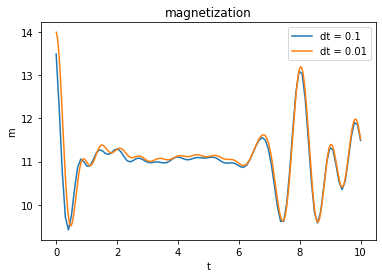

In [9]:
for i, dt in enumerate(dts_TEBD):
    N = (int)(np.ceil(t_stop/dt))
    ts = np.linspace(0, t_stop, N)
    plt.plot(ts, ms_TEBD[i], label="dt = "+str(dt))
plt.legend()
plt.title("magnetization")
plt.ylabel("m")
plt.xlabel("t")
plt.show()

# TDVP2

In [11]:
dts_TDVP_2 = [0.1, 0.01]

ms_TDVP_2 = [[] for i in range(len(dts_TDVP_2))]

model = tfi_model.TFIModel(L, J, g)

chi_max = 10
eps = 1.e-10

for i, dt in enumerate(dts_TDVP_2):
    start = time.time()
    print("computing for dt =", dt)
    N = (int)(np.ceil(t_stop/dt))
    psi = MPS_all_spin_up.copy()
    engine = tdvp.TDVP2_Engine(psi, model, dt, chi_max, eps)
    for _ in tqdm(range(N)):
        engine.sweep()
        ms_TDVP_2[i].append(np.real_if_close(np.sum(engine.psi.site_expectation_value(sigma_z))))
    end = time.time()
    print("took", end-start, "seconds")

computing for dt = 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

took 24.79338002204895 seconds
computing for dt = 0.01


  0%|          | 0/1000 [00:00<?, ?it/s]

took 252.0314803123474 seconds


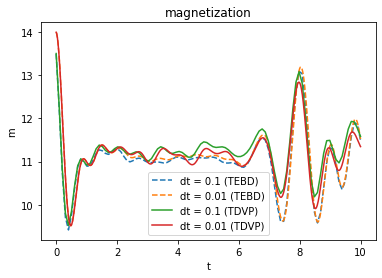

In [12]:
for i, dt in enumerate(dts_TEBD):
    N = (int)(np.ceil(t_stop/dt))
    ts = np.linspace(0, t_stop, N)
    plt.plot(ts, ms_TEBD[i], "--", label="dt = "+str(dt)+" (TEBD)")
for i, dt in enumerate(dts_TDVP_2):
    N = (int)(np.ceil(t_stop/dt))
    ts = np.linspace(0, t_stop, N)
    plt.plot(ts, ms_TDVP_2[i], label="dt = "+str(dt)+" (TDVP)")
plt.legend()
plt.title("magnetization")
plt.ylabel("m")
plt.xlabel("t")
plt.show()

TDVP achieves roughly the same results as TEBD, but is roughly 20 times slower.
The advantage of course is that TDVP works with MPOS and can therefore also describe long-range interactions in contrast to TEBD which can only describe nearest-neighbour interactions.

# TDVP1 (fixed bond dimension)

In [15]:
dts_TDVP_1 = [0.1, 0.01]

ms_TDVP_1 = [[] for i in range(len(dts_TDVP_1))]

model = tfi_model.TFIModel(L, J, g)

chi_max = 20
eps = 1.e-10

for i, dt in enumerate(dts_TDVP_1):
    start = time.time()
    print("computing for dt =", dt)
    N = (int)(np.ceil(t_stop/dt))
    psi = mps.MPS.initialize_spinup(L, chimax=chi_max)
    engine = tdvp.TDVP1_Engine(psi, model, dt)
    for _ in tqdm(range(N)):
        engine.sweep()
        ms_TDVP_1[i].append(np.real_if_close(np.sum(engine.psi.site_expectation_value(sigma_z))))
    end = time.time()
    print("took", end-start, "seconds")

computing for dt = 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

took 72.362478017807 seconds
computing for dt = 0.01


  0%|          | 0/1000 [00:00<?, ?it/s]

took 1136.440800666809 seconds


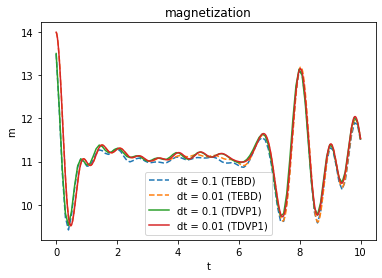

In [16]:
for i, dt in enumerate(dts_TEBD):
    N = (int)(np.ceil(t_stop/dt))
    ts = np.linspace(0, t_stop, N)
    plt.plot(ts, ms_TEBD[i], "--", label="dt = "+str(dt)+" (TEBD)")
for i, dt in enumerate(dts_TDVP_1):
    N = (int)(np.ceil(t_stop/dt))
    ts = np.linspace(0, t_stop, N)
    plt.plot(ts, ms_TDVP_1[i], label="dt = "+str(dt)+" (TDVP1)")
plt.legend()
plt.title("magnetization")
plt.ylabel("m")
plt.xlabel("t")
plt.show()